# MiniMS Data Wrangling Project

David Nerguizian

I am working on a project with a new MiniMS system to try and develop a point-of-care test to determine levels of HIV medication (Cabotegravir [CAB] and Rilpivirine [RPV]) in blood. Normally mass spec systems come with robust data analysis software, but this is a relatively new technology and there is no built in data analysis software associated with the system. 

Each sample is analyzed for CAB and RPV along with their stable-labeled interenal standards (isotopically labeled CAB and RPV). The data file includes two columns per compound (m/z and inensity) and the compounds are cycled through 10 times total, resulting in a file that is 80 columns wide and 1,000 rows deep.

My goal is to obtain the peak intensity for the peaks representing CAB, CAB-IS, RPV, and RPV-IS, calculate average intensities across the 10 cycles for each compound, plot the data, and determine ratios of analyte to IS intensities.

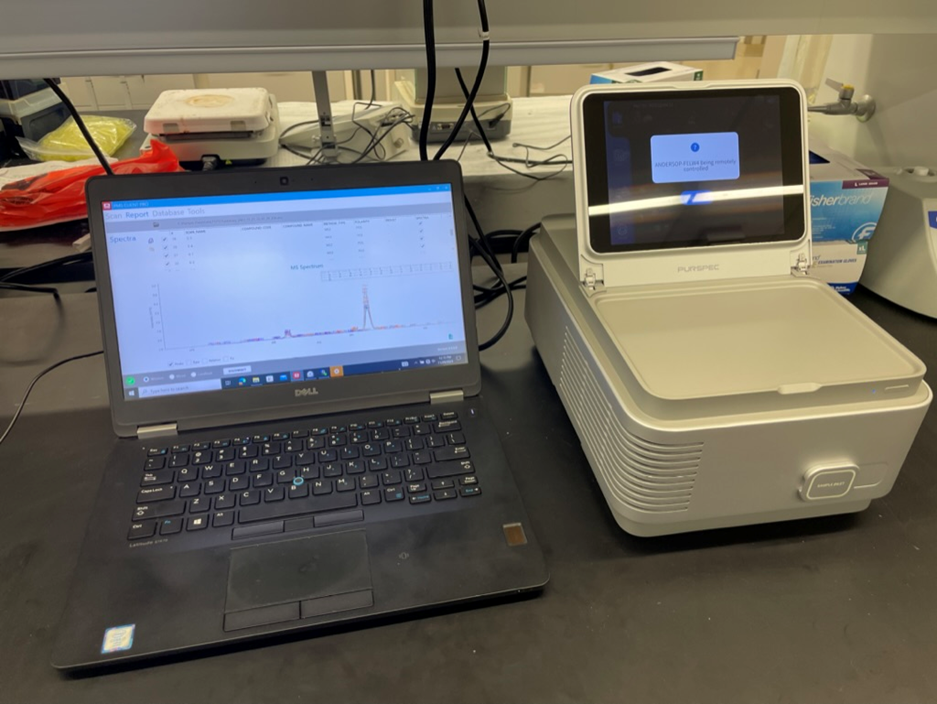 
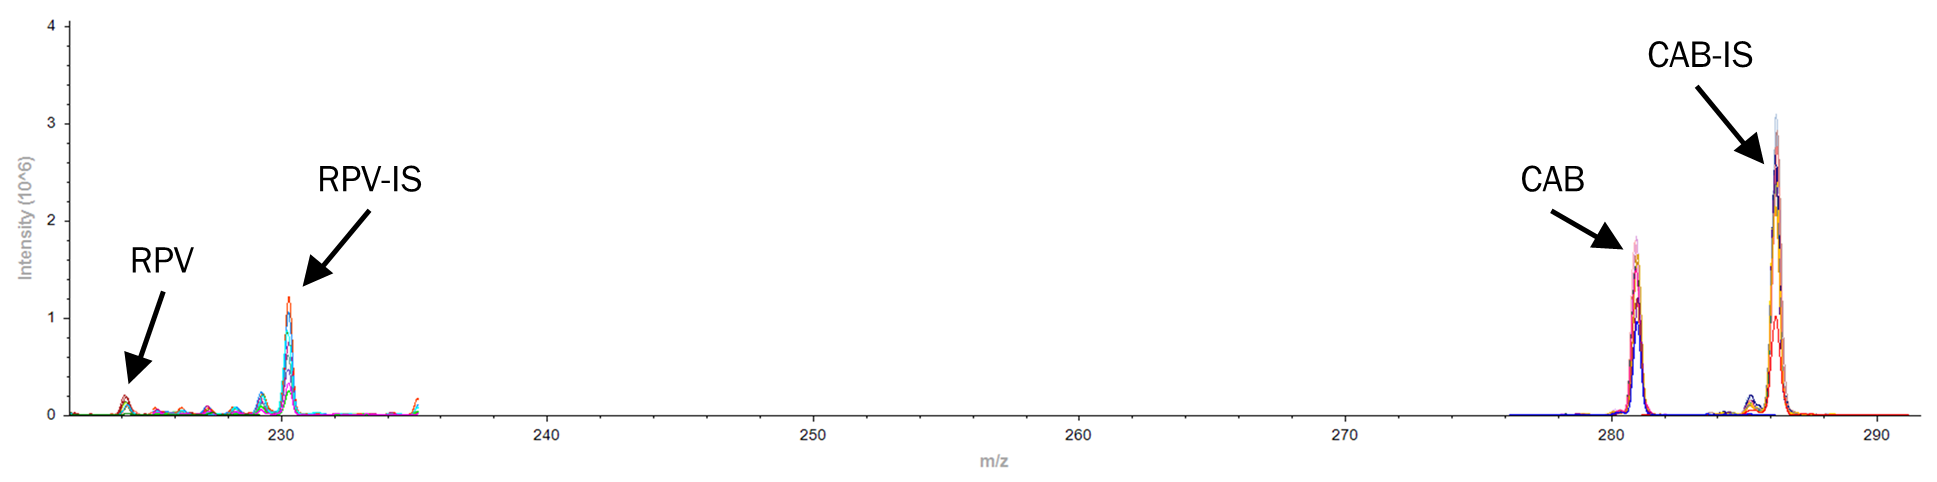

In [33]:
# Import .csv file from MS analysis

import pandas as pd
import os
import csv
import numpy as np
from scipy.signal import find_peaks
from statistics import mean
from numpy import std
import plotly.graph_objects as go


samplename = '100_100-1'

df = pd.read_csv(samplename+'.csv')
df

x1    y1          x2  y2          x3    y3          x4     y4  \
0    276.207480   391  281.206093   0  219.223606  7705  225.221882  22291   
1    276.217478   509  281.216091   0  219.233603  8192  225.231879  24955   
2    276.227475   654  281.226088   0  219.243601  8684  225.241876  27960   
3    276.237472   827  281.236085   0  219.253598  9171  225.251873  31271   
4    276.247469  1031  281.246082   0  219.263595  9640  225.261870  34829   
..          ...   ...         ...  ..         ...   ...         ...    ...   
995  286.154725    83  291.153347   0  229.170750  4498  235.169036  68367   
996  286.164722   117  291.163344   0  229.180747  4888  235.179033  67720   
997  286.174719   162  291.173341   0  229.190744  5322  235.189030  66757   
998  286.184716   220  291.183338   0  229.200741  5798  235.199027  65594   
999  286.194714   296  291.193336   0  229.210738  6315  235.209024  64354   

             x5  y5  ...         x38  y38         x39  y39         x40    y40  \
0    276.207480   0  ...  281.206093    0  219.223606   85  225.221882  23358   
1    276.217478   0  ...  281.216091    0  219.233603   62  225.231879  23158   
2    276.227475   0  ...  281.226088    0  219.243601   45  225.241876  22817   
3    276.237472   0  ...  281.236085    0  219.253598   35  225.251873  23510   
4    276.247469   0  ...  281.246082    0  219.263595   31  225.261870  24181   
..          ...  ..  ...         ...  ...         ...  ...         ...    ...   
995  286.154725   0  ...  291.153347    0  229.170750    0  235.169036  32815   
996  286.164722   0  ...  291.163344    0  229.180747    0  235.179033  33808   
997  286.174719   0  ...  291.173341    0  229.190744    0  235.189030  34548   
998  286.184716   0  ...  291.183338    0  229.200741    0  235.199027  35049   
999  286.194714   0  ...  291.193336    0  229.210738    1  235.209024  35333   

     Unnamed: 80  Unnamed: 81  Unnamed: 82  Unnamed: 83  
0            NaN          NaN          NaN          NaN  
1            NaN          NaN  UI Settings          NaN  
2            NaN          NaN          Raw        False  
3            NaN          NaN     Relative        False  
4            NaN          NaN       Filter         none  
..           ...          ...          ...          ...  
995          NaN          NaN          NaN          NaN  
996          NaN          NaN          NaN          NaN  
997          NaN          NaN          NaN          NaN  
998          NaN          NaN          NaN          NaN  
999          NaN          NaN          NaN          NaN  

[1000 rows x 84 columns]

In [46]:
# Plot CAB data to show an example of what one of the compounds looks like

fig_CAB_Ex = go.Figure(data=go.Scatter(x=df['x1'], y=df['y1'], mode='lines'))
fig_CAB_Ex.update_layout(title='Example CAB Mass Spectrum', xaxis_title='m/z', yaxis_title='Intensity')
fig_CAB_Ex.show()

## Wrangle Step 1

I want to break the imported .csv file into smaller .csv files, one for each cycle through the compounds, and store them in a newly created folder. 

Each smaller .csv file should have 8 rows (one m/z and intensity column for each of the 4 compounds) and 1000 rows.

I want to create individual .csv files in case I want to go and do anything with the data from an individual cycle of the run.

In [35]:
# Make a new folder, split .csv file with all data into 10 individual .csv files, one for each cycle through the compounds.

# to make a new folder, used https://stackoverflow.com/questions/1274405/how-to-create-new-folder
newpath = r'split_cycles_'+samplename+r'/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

# Loop through the columns of the full .csv file by 4s and save the corresponding x and y columns to a new file labeled 'cycle_#'  
j = 1
for i in range(1,40,4):
    #print(i)
    filename = 'cycle_'+str(j)+'.csv'
    j+=1

    x1 = df['x'+str(i)]
    x2 = df['x'+str(i+1)]
    x3 = df['x'+str(i+2)]
    x4 = df['x'+str(i+3)]

    y1 = df['y'+str(i)]
    y2 = df['y'+str(i+1)]
    y3 = df['y'+str(i+2)]
    y4 = df['y'+str(i+3)]

    # create a new data frame with the split data and rename columns to be x1, y1 through x4, y4
    df_subset = pd.DataFrame(columns = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])
    df_subset['x1'] = x1
    df_subset['x2'] = x2
    df_subset['x3'] = x3
    df_subset['x4'] = x4

    df_subset['y1'] = y1
    df_subset['y2'] = y2
    df_subset['y3'] = y3
    df_subset['y4'] = y4

    # export .csv file 
    df_subset.to_csv(newpath+filename)

In [36]:
# Check if data is being split appropriately
splitdf = pd.read_csv(newpath+'cycle_1.csv')
splitdf

Unnamed: 0          x1    y1          x2  y2          x3    y3  \
0             0  276.207480   391  281.206093   0  219.223606  7705   
1             1  276.217478   509  281.216091   0  219.233603  8192   
2             2  276.227475   654  281.226088   0  219.243601  8684   
3             3  276.237472   827  281.236085   0  219.253598  9171   
4             4  276.247469  1031  281.246082   0  219.263595  9640   
..          ...         ...   ...         ...  ..         ...   ...   
995         995  286.154725    83  291.153347   0  229.170750  4498   
996         996  286.164722   117  291.163344   0  229.180747  4888   
997         997  286.174719   162  291.173341   0  229.190744  5322   
998         998  286.184716   220  291.183338   0  229.200741  5798   
999         999  286.194714   296  291.193336   0  229.210738  6315   

             x4     y4  
0    225.221882  22291  
1    225.231879  24955  
2    225.241876  27960  
3    225.251873  31271  
4    225.261870  34829  
..          ...    ...  
995  235.169036  68367  
996  235.179033  67720  
997  235.189030  66757  
998  235.199027  65594  
999  235.209024  64354  

[1000 rows x 9 columns]

## Wrangle Step 2

Define a function to identify each peak present in the data for each compound

In [37]:
# This code is based off of a template which was sent to me by PURSPEC, the maker of the MiniMS system

# Takes in intensity and m/z data and identifies each peak present in the data based on some detection parameters
def find_peaks_and_calculate_area(data_array, mz_array):
    peaks_positions, peaks_properties = find_peaks(
        data_array,
        height=8e3,
        threshold=0,
        distance=100,
        prominence=5e-3,
        width=(5, 60),
        wlen=120,
        plateau_size=0,
        rel_height=0.1,
    )

    # Create an empty list for peaks and set peak_index (peak number) to 0
    peaks = []
    peak_index = 0

    # For each peak identified, define the position (peak data index), m/z where the peak is seen, inesnity of the peak, and area of the peak
    # Add data to dictionary of peaks and return data
    for position in peaks_positions:
        
        # Define left and right bases of peaks, attributes of peak_properties
        left_bases = peaks_properties["left_bases"][peak_index]
        right_bases = peaks_properties["right_bases"][peak_index]

        # Calculate area of peaks
        peak_area = np.array(data_array[left_bases:right_bases]).sum(dtype=np.int64)
        peak_index += 1

        # create a peak dictionary
        peak = {
            "position": position,
            "mz": mz_array[position],
            "intensity": data_array[position],
            "area": peak_area,
        }
        print('Funtion 1: ',peak)
        peaks.append(peak)

    # return the list of peaks
    return peaks

## Wrangle Step 3

Define a function to read through each split .csv file and return peak information for each of the peaks of interest.

In [38]:
# This function is also based on the python file sent to me by PURSPEC.

def load_csv_data(csv_file_name):
    print(f"csv_file_name = {csv_file_name}")

    # Create empty ilsts for each compound m/z and intensity data
    CAB_mz_array = []
    CABIS_mz_array = []
    RPV_mz_array = []
    RPVIS_ms_array = []
    CAB_intensity_array = []
    CABIS_intensity_array = []
    RPV_intensity_array = []
    RPVIS_intensity_array = []

    # reading csv file
    with open(csv_file_name, "r") as csv_file:
        # creating a csv reader object
        csv_reader = csv.reader(csv_file)

        # extracting field names through first row
        fields = next(csv_reader)

        # extracting each data row one by one
        # if multiple spectra are in one csv file, loop through them.
        # While this says row, it means column, not sure why
        for row in csv_reader:
            CAB_mz_array.append(row[1])
            CABIS_mz_array.append(row[3])
            RPV_mz_array.append(row[5])
            RPVIS_ms_array.append(row[7])
            CAB_intensity_array.append(row[2])
            CABIS_intensity_array.append(row[4])
            RPV_intensity_array.append(row[6])
            RPVIS_intensity_array.append(row[8])

    print(f"mz_array size: {len(CAB_mz_array)}")
    print(f"intensity_array size: {len(CAB_intensity_array)}")

    # Use function defined above to get peak data for each compound
    CAB_peaks = find_peaks_and_calculate_area(CAB_intensity_array, CAB_mz_array)
    CABIS_peaks = find_peaks_and_calculate_area(CABIS_intensity_array, CABIS_mz_array)
    RPV_peaks = find_peaks_and_calculate_area(RPV_intensity_array, RPV_mz_array)    
    RPVIS_peaks = find_peaks_and_calculate_area(RPVIS_intensity_array, RPVIS_ms_array)

    # Find data for Peaks of Interest

    # Look through list of peaks and pick out peak data in mass range that is appropriate for compound of interest
    CAB_peaks_trimmed = [peak for peak in CAB_peaks if float(peak['mz']) > 280.5 and float(peak['mz']) < 281.5]
    CAB_intensity = 0
    CAB_area = 0

    # Loop through peaks and get intensity and area data
    for peak in CAB_peaks_trimmed:
        CAB_intensity = float(peak['intensity'])
        CAB_area = float(peak['area'])
    print('CAB Intensity:', CAB_intensity)
    print('CAB area:', CAB_area)
    print()

    # Repeat above for each of the compounds

    CABIS_peaks_trimmed = [peak for peak in CABIS_peaks if float(peak['mz']) > 285.5 and float(peak['mz']) < 286.5]
    CABIS_intensity = 0
    CABIS_area = 0
    for peak in CABIS_peaks_trimmed:
        CABIS_intensity = float(peak['intensity'])
        CABIS_area = float(peak['area'])
    print('CABIS Intensity:', CABIS_intensity)
    print('CABIS area:', CABIS_area)
    print()

    RPV_peaks_trimmed = [peak for peak in RPV_peaks if float(peak['mz']) > 223.6 and float(peak['mz']) < 224.5]
    RPV_intensity = 0
    RPV_area = 0
    for peak in RPV_peaks_trimmed:
        RPV_intensity = float(peak['intensity'])
        RPV_area = float(peak['area'])
    print('RPV Intensity:', RPV_intensity)
    print('RPV area:', RPV_area)
    print()

    RPVIS_peaks_trimmed = [peak for peak in RPVIS_peaks if float(peak['mz']) > 229.5 and float(peak['mz']) < 230.5]
    RPVIS_intensity = 0
    RPVIS_area = 0
    for peak in RPVIS_peaks_trimmed:
        RPVIS_intensity = float(peak['intensity'])
        RPVIS_area = float(peak['area'])
    print('RPVIS Intensity:', RPVIS_intensity)
    print('RPVIS area:', RPVIS_area)
    print()

    # Return peak data for each of the peaks of interest for each of the compounds

    return CAB_intensity, CABIS_intensity, RPV_intensity, RPVIS_intensity, CAB_area, CABIS_area, RPV_area, RPVIS_area

## Wrangle Step 4

Use load_csv_data function to generate peak data for each peak of interest from each of the 10 cycles

In [39]:
# Create empty lists to hold data for all 10 cycles of each compound 
# Values = intensity, indicies = data point collection sequence, areas = area
CABvalues = []
CABISvalues = []
RPVvalues = []
RPVISvalues = []
CABindices = []
CABISindices = []
RPVindices = []
RPVISindices = []
CABareas = []
CABISareas = []
RPVareas = []
RPVISareas = []

# Define indicies so plotting of data can be accomplished later
for j in range(1,40,4):
    CABindices.append(j)
    CABISindices.append(j+1)
    RPVindices.append(j+2)
    RPVISindices.append(j+3)

print('CAB indicies: ',CABindices)
print('CAB-IS indicies: ',CABISindices)
print('RPV indicies: ',RPVindices)
print('RPV-IS indicies: ',RPVISindices)

CAB indicies:  [1, 5, 9, 13, 17, 21, 25, 29, 33, 37]
CAB-IS indicies:  [2, 6, 10, 14, 18, 22, 26, 30, 34, 38]
RPV indicies:  [3, 7, 11, 15, 19, 23, 27, 31, 35, 39]
RPV-IS indicies:  [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]


In [40]:
# Cycle through each of the split .csv files and obtain the compound peak intensities and areas
for i in range(1,11):
    path = 'split_cycles_'+samplename+'/'
    filename = 'cycle_'+str(i)+'.csv'

    # Use the load_csv_data function to get necessary dat for each peak
    CAB_intensity, CABIS_intensity, RPV_intensity, RPVIS_intensity, CAB_area, CABIS_area, RPV_area, RPVIS_area = load_csv_data(path+filename)
    CABvalues.append(CAB_intensity)
    CABISvalues.append(CABIS_intensity)
    RPVvalues.append(RPV_intensity)
    RPVISvalues.append(RPVIS_intensity)
    CABareas.append(CAB_area)
    CABISareas.append(CABIS_area)
    RPVareas.append(RPV_area)
    RPVISareas.append(RPVIS_area)

print('All CAB Intensities: ',CABvalues)
print('All CAB-IS Intensities: ',CABISvalues)
print('All RPV Intensities: ',RPVvalues)
print('All RPV-IS Intensities: ',RPVISvalues)

csv_file_name = split_cycles_100_100-1/cycle_1.csv
mz_array size: 1000
intensity_array size: 1000
Funtion 1:  {'position': 481, 'mz': '281.016146094981', 'intensity': '1944036', 'area': 69571640}
Funtion 1:  {'position': 34, 'mz': '281.545999313191', 'intensity': '15126', 'area': 374455}
Funtion 1:  {'position': 403, 'mz': '285.234978762519', 'intensity': '103574', 'area': 4248462}
Funtion 1:  {'position': 505, 'mz': '286.254697085738', 'intensity': '2093105', 'area': 75990885}
Funtion 1:  {'position': 11, 'mz': '219.33357470228', 'intensity': '11438', 'area': 304459}
Funtion 1:  {'position': 178, 'mz': '221.003094068601', 'intensity': '18324', 'area': 419636}
Funtion 1:  {'position': 283, 'mz': '222.052792127412', 'intensity': '9810', 'area': 333802}
Funtion 1:  {'position': 498, 'mz': '224.20217447789', 'intensity': '100848', 'area': 3413528}
Funtion 1:  {'position': 620, 'mz': '225.421824362827', 'intensity': '9653', 'area': 199965}
Funtion 1:  {'position': 891, 'mz': '228.131047594

## Wrangle Step 5

Calculate means, standard deviations, %CVs, and analyte/IS ratios

In [41]:
# Calculate means and standard deviations for each compound
CAB_mean = mean(CABvalues)
CAB_sd = std(CABvalues)
CABIS_mean = mean(CABISvalues)
CABIS_sd = std(CABISvalues)
RPV_mean = mean(RPVvalues)
RPV_sd = std(RPVvalues)
RPVIS_mean = mean(RPVISvalues)
RPVIS_sd = std(RPVISvalues)

# Calculate %CVs
print('CAB Mean:', CAB_mean)
CABcv = CAB_sd/CAB_mean*100
print('CAB %CV:', CABcv)

print('CABIS Mean:', CABIS_mean)
CABIScv = CABIS_sd/CABIS_mean*100
print('CABIS %CV:', CABIScv)

print('RPV Mean:', RPV_mean)
RPVcv = RPV_sd/RPV_mean*100
print('RPV %CV:', RPVcv)

print('RPVIS Mean:', RPVIS_mean)
RPVIScv = RPVIS_sd/RPVIS_mean*100
print('RPVIS %CV:', RPVIScv)
print()

# Calculate Ratios
CABratio = CABIS_mean/CAB_mean
RPVratio = RPVIS_mean/RPV_mean
print('CAB Ratio:', CABratio)
print('RPV Ratio:', RPVratio)



CAB Mean: 1980928.3
CAB %CV: 17.237117313963665
CABIS Mean: 2009493.1
CABIS %CV: 9.37728581150288
RPV Mean: 128667.2
RPV %CV: 25.596845130879736
RPVIS Mean: 847294.3
RPVIS %CV: 6.533542941501712

CAB Ratio: 1.0144199060612138
RPV Ratio: 6.585161564097144


## Wrangle Step 6

Create plots of each compound showing 10 data points (1 from each cycle) as well as a line for the mean

In [42]:
# Create a plot for CAB
fig_int = go.Figure(data=go.Scatter(x=CABindices, y=CABvalues, mode='lines+markers'))
fig_int.add_hline(y=CAB_mean)
fig_area = go.Figure(data=go.Scatter(x=CABindices, y=CABareas, mode='lines+markers'))

fig_int.update_layout(title='CAB', xaxis_title='Scan Number', yaxis_title='Intensity')
fig_area.update_layout(title='CAB Area vs. Scan#')

fig_int.show()
# fig_area.show()

In [43]:
# Create a plot for CAB-IS
fig_int = go.Figure(data=go.Scatter(x=CABISindices, y=CABISvalues, mode='lines+markers'))
fig_int.add_hline(y=CABIS_mean)
fig_area = go.Figure(data=go.Scatter(x=CABISindices, y=CABISareas, mode='lines+markers'))

fig_int.update_layout(title='CAB-IS', xaxis_title='Scan Number', yaxis_title='Intensity')
fig_area.update_layout(title='CABIS Area vs. Scan#')

fig_int.show()
#fig_area.show()

In [44]:
# Create a plot for RPV
fig_int = go.Figure(data=go.Scatter(x=RPVindices, y=RPVvalues, mode='lines+markers'))
fig_int.add_hline(y=RPV_mean)
fig_area = go.Figure(data=go.Scatter(x=RPVindices, y=RPVareas, mode='lines+markers'))

fig_int.update_layout(title='RPV', xaxis_title='Scan Number', yaxis_title='Intensity')
fig_area.update_layout(title='RPV Area vs. Scan#')

fig_int.show()
#fig_area.show()

In [45]:
# Create a plot for RPV-IS
fig_int = go.Figure(data=go.Scatter(x=RPVISindices, y=RPVISvalues, mode='lines+markers',))
fig_int.add_hline(y=RPVIS_mean)
fig_area = go.Figure(data=go.Scatter(x=RPVISindices, y=RPVISareas, mode='lines+markers',))

fig_int.update_layout(title='RPV-IS', xaxis_title='Scan Number', yaxis_title='Intensity')
fig_area.update_layout(title='RPVIS Area vs. Scan#')

fig_int.show()
#fig_area.show()

## Future Directions

I will be running multiple samples per day and it would be nice to automate this to cycle through each of the .csv files created and then create a report detailing the results for each sample.

I will also generate data to produce a standard curve. I want to be able to take that data, generate a curve, and use the curve to determine the concentration of an unknown sample.